In [ ]:
!pip install nltk sentencepiece

# 1. 데이터 셋 만들기

In [ ]:
import nltk as nltk
import os
import csv

nltk.download('movie_reviews')

neg_folder_path = "/root/nltk_data/corpora/movie_reviews/neg"
pos_folder_path = "/root/nltk_data/corpora/movie_reviews/pos"
output_csv_path = "movie_reviews.csv"


data = []
data_id_counter = 0



for filename in os.listdir(neg_folder_path):
    if filename.endswith(".txt"):
        filepath = os.path.join(neg_folder_path, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                data.append({"ID": data_id_counter, "content": line.strip(), "label": 0})
                data_id_counter += 1

for filename in os.listdir(pos_folder_path):
    if filename.endswith(".txt"):
        filepath = os.path.join(pos_folder_path, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                data.append({"ID": data_id_counter, "content": line.strip(), "label": 1})
                data_id_counter += 1

with open(output_csv_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=["ID", "content", "label"])
    writer.writeheader()
    writer.writerows(data)

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


# 2. 학습/테스트 데이터 나누기

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("movie_reviews.csv")
display(df.info())
display(df.head())

# 0/1 레이블 비율 확인
label_counts = df['label'].value_counts()
label_proportions = df['label'].value_counts(normalize=True)

print("레이블 별 개수:")
print(label_counts)
print("\n레이블 별 비율:")
print(label_proportions)

# 0/1 레이블 비율을 지키며 나누기
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size=0.1, stratify=df['label'], random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64720 entries, 0 to 64719
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       64720 non-null  int64 
 1   content  64720 non-null  object
 2   label    64720 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


None

,ID,content,label
0,0,wonderland is a rather sugary romance film tha...,0
1,1,you can see its plot developing from a mile aw...,0
2,2,are lured into its benign story of a single 29...,0
3,3,"this is a star oriented film , and the star wh...",0
4,4,"that this is a dating film , about singles who...",0


레이블 별 개수:
label
1    32937
0    31783
Name: count, dtype: int64

레이블 별 비율:
label
1    0.508915
0    0.491085
Name: proportion, dtype: float64
Shape of X_train: (58248,)
Shape of X_test: (6472,)
Shape of y_train: (58248,)
Shape of y_test: (6472,)


# 3. 단어 사전(vocab) 만들기

In [ ]:
import sentencepiece as spm


output_txt_path = "X_train.txt"

with open(output_txt_path, 'w', encoding='utf-8') as f:
    for review in X_train:
        f.write(review + '\n')


input_file = "X_train.txt"
model_prefix = 'movie_review_unigram'
model_type = 'unigram'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f'--input={input_file} --model_prefix={model_prefix} --model_type={model_type} --vocab_size={vocab_size}'
)

sp = spm.SentencePieceProcessor()
sp.load('movie_review_unigram.model')
vocabulary = [sp.id_to_piece(i) for i in range(sp.get_piece_size())]
print(vocabulary)

['<unk>', '<s>', '</s>', 's', '▁the', '▁,', '▁.', '▁a', '▁and', '▁of', '▁to', "'", '▁', '▁is', '▁in', 'ing', 'ed', '▁"', '▁it', '▁that', '-', 'ly', 't', '▁)', '▁(', '▁with', '▁for', '▁film', '▁his', '▁i', '▁as', 'y', '▁this', '▁he', 'd', '▁but', '▁on', '▁be', 'e', '▁are', '▁by', '▁who', '▁one', '▁an', '▁movie', '▁not', '▁you', 'from', '▁was', '▁have', '▁her', '▁at', '▁has', '▁all', '▁they', '▁so', '▁like', 'er', '▁out', '▁?', '▁there', '▁about', '▁up', '▁more', '▁what', '▁when', '▁she', '▁or', '▁some', '▁which', '▁their', '▁:', '▁can', '▁we', 'n', '▁just', '▁if', '▁no', '▁him', '▁even', '▁do', '▁into', '▁time', '▁good', '▁than', '▁only', '▁most', '▁will', 'a', 'r', 're', '▁story', '▁character', '▁would', 'se', '▁much', '▁get', '▁been', '▁other', 'es', '▁also', 'm', '▁well', '▁two', '▁see', '▁over', '▁first', '▁very', 'able', 'l', '▁;', '▁after', '▁them', '▁characters', '▁way', '▁!', '▁make', '▁play', '▁t', '▁me', 'because', '▁any', '▁seem', '▁know', '▁my', '▁year', '▁plot', '▁come', '▁

# 4. 학습/검증 데이터 나누기

In [ ]:
from sklearn.model_selection import train_test_split

X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

print("Shape of X_train_split:", X_train_split.shape)
print("Shape of X_valid_split:", X_valid_split.shape)
print("Shape of y_train_split:", y_train_split.shape)
print("Shape of y_valid_split:", y_valid_split.shape)

Shape of X_train_split: (46598,)
Shape of X_valid_split: (11650,)
Shape of y_train_split: (46598,)
Shape of y_valid_split: (11650,)


# 5. 학습/검증/테스트 데이터 토큰화하기

In [ ]:
X_train_tokenized = [sp.encode_as_ids(review) for review in X_train_split]
X_valid_tokenized = [sp.encode_as_ids(review) for review in X_valid_split]
X_test_tokenized = [sp.encode_as_ids(review) for review in X_test]

print("First tokenized training review:", X_train_tokenized[0])
print("First tokenized validation review:", X_valid_tokenized[0])
print("First tokenized test review:", X_test_tokenized[0])

First tokenized training review: [24, 6439, 382, 20, 12, 0, 1832, 38, 175, 178, 46, 437, 12, 0, 115, 115]
First tokenized validation review: [33, 100, 52, 4, 1466, 1427, 907, 8, 348, 31, 4132, 3653, 24, 1834, 901, 153, 34, 99, 23, 10, 1099, 14, 25, 3438, 30, 28, 1203, 4132, 55, 30, 10, 177, 78, 4, 850, 3075, 2465, 3, 186, 3, 69, 33, 898, 21, 1334, 3, 6]
First tokenized test review: [18, 13, 4, 324, 9, 126, 25, 69, 46, 39, 148, 351, 41, 87, 1522, 20, 4936, 969, 5, 8, 1749, 21, 18, 13, 4300, 1522, 20, 4936, 15, 4, 885, 6]


# 6. 학습/검증/테스트 데이터 가장 긴 길이로 패딩처리하기

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

# max_len = max(len(seq) for seq in X_train_tokenized + X_valid_tokenized + X_test_tokenized)
max_len = 100

X_train_padded = pad_sequence([torch.tensor(seq) for seq in X_train_tokenized], batch_first=True, padding_value=0)
X_valid_padded = pad_sequence([torch.tensor(seq) for seq in X_valid_tokenized], batch_first=True, padding_value=0)
X_test_padded = pad_sequence([torch.tensor(seq) for seq in X_test_tokenized], batch_first=True, padding_value=0)

print("Shape of X_train_padded:", X_train_padded.shape)
print("Shape of X_valid_padded:", X_valid_padded.shape)
print("Shape of X_test_padded:", X_test_padded.shape)
print("Max sequence length:", max_len)

Shape of X_train_padded: torch.Size([46598, 217])
Shape of X_valid_padded: torch.Size([11650, 266])
Shape of X_test_padded: torch.Size([6472, 191])
Max sequence length: 100


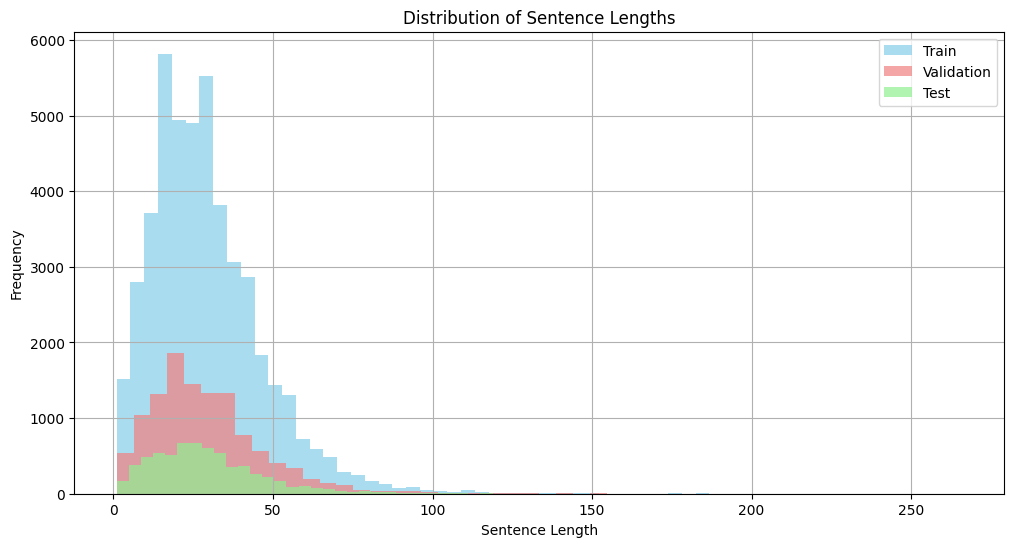

In [ ]:
import matplotlib.pyplot as plt

# Calculate sentence lengths
train_lengths = [len(seq) for seq in X_train_tokenized]
valid_lengths = [len(seq) for seq in X_valid_tokenized]
test_lengths = [len(seq) for seq in X_test_tokenized]

# Plotting the distribution of sentence lengths
plt.figure(figsize=(12, 6))

plt.hist(train_lengths, bins=50, alpha=0.7, label='Train', color='skyblue')
plt.hist(valid_lengths, bins=50, alpha=0.7, label='Validation', color='lightcoral')
plt.hist(test_lengths, bins=50, alpha=0.7, label='Test', color='lightgreen')


plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# 7. PyTorch Dataset 및 DataLoader 생성

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MovieReviewDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx]
        if self.labels is not None:
            labels = torch.tensor(self.labels.iloc[idx], dtype=torch.float32)
            return features, labels
        else:
            return features


train_dataset = MovieReviewDataset(X_train_padded, y_train_split)
valid_dataset = MovieReviewDataset(X_valid_padded, y_valid_split)
test_dataset = MovieReviewDataset(X_test_padded, y_test)

batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in valid_loader:", len(valid_loader))
print("Number of batches in test_loader:", len(test_loader))

Number of batches in train_loader: 92
Number of batches in valid_loader: 23
Number of batches in test_loader: 13


# 8. PyTorch 모델 정의 (Embedding + RNN)

In [ ]:
import torch
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=False, dropout=dropout, batch_first=True)

        # Replace the single fc layer with three fc layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2) # First FC layer
        self.fc2 = nn.Linear(hidden_dim // 2, hidden_dim // 4) # Second FC layer
        self.fc3 = nn.Linear(hidden_dim // 4, output_dim) # Third (output) FC layer

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU() # Using ReLU activation function

    def forward(self, text):
        # text shape: [batch size, sequence length]

        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch size, sequence length, embedding dim]

        output, hidden = self.rnn(embedded)
        # output shape: [batch size, sequence length, hidden dim]
        # hidden shape: [num_layers, batch size, hidden dim] (if not bidirectional)

        # We only care about the output from the last time step
        last_hidden = output[:, -1, :]
        # last_hidden shape: [batch size, hidden dim]

        # Pass through the new sequence of FC layers
        # x = self.dropout(last_hidden)
        x = last_hidden
        x = self.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout after activation
        x = self.relu(self.fc2(x))
        x = self.dropout(x) # Apply dropout after activation
        output = self.fc3(x) # Final output layer (no activation here for BCEWithLogitsLoss)

        # output shape: [batch size, output dim]

        return output


class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=False, dropout=dropout, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.fc3 = nn.Linear(hidden_dim // 4, output_dim)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, text):
        # text shape: [batch size, sequence length]

        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch size, sequence length, embedding dim]

        output, (hidden, cell) = self.lstm(embedded)
        # output shape: [batch size, sequence length, hidden dim]
        # hidden shape: [num_layers, batch size, hidden dim]

        last_hidden = output[:, -1, :]
        # last_hidden shape: [batch size, hidden dim]

        x = last_hidden
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        output = self.fc3(x)

        # output shape: [batch size, output dim]

        return output


class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=False, dropout=dropout, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.fc3 = nn.Linear(hidden_dim // 4, output_dim)


        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, text):
        # text shape: [batch size, sequence length]

        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch size, sequence length, embedding dim]

        output, hidden = self.gru(embedded)
        # output shape: [batch size, sequence length, hidden dim]
        # hidden shape: [num_layers, batch size, hidden dim]

        last_hidden = output[:, -1, :]
        # last_hidden shape: [batch size, hidden dim]

        x = last_hidden
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        output = self.fc3(x)


        # output shape: [batch size, output dim]

        return output

class SentimentBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout, batch_first=True)

        # The output of a bidirectional LSTM is hidden_dim * 2
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, text):
        # text shape: [batch size, sequence length]

        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch size, sequence length, embedding dim]

        output, (hidden, cell) = self.lstm(embedded)
        # output shape: [batch size, sequence length, hidden_dim * 2]
        # hidden shape: [num_layers * 2, batch size, hidden_dim]

        # We concatenate the hidden states from the forward and backward directions
        last_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        # last_hidden shape: [batch size, hidden_dim * 2]


        x = last_hidden
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        output = self.fc3(x)

        # output shape: [batch size, output dim]

        return output

class SentimentBiGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout, batch_first=True)

        # The output of a bidirectional GRU is hidden_dim * 2
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)


        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, text):
        # text shape: [batch size, sequence length]

        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch size, sequence length, embedding dim]

        output, hidden = self.gru(embedded)
        # output shape: [batch size, sequence length, hidden_dim * 2]
        # hidden shape: [num_layers * 2, batch size, hidden_dim]

        # We concatenate the hidden states from the forward and backward directions
        last_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        # last_hidden shape: [batch size, hidden_dim * 2]


        x = last_hidden
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        output = self.fc3(x)


        # output shape: [batch size, output dim]

        return output

class SentimentBiRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout, batch_first=True)

        # The output of a bidirectional RNN is hidden_dim * 2
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, text):
        # text shape: [batch size, sequence length]

        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch size, sequence length, embedding dim]

        output, hidden = self.rnn(embedded)
        # output shape: [batch size, sequence length, hidden_dim * 2]
        # hidden shape: [num_layers * 2, batch size, hidden_dim]

        # We concatenate the hidden states from the forward and backward directions
        last_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        # last_hidden shape: [batch size, hidden_dim * 2]

        x = last_hidden
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        output = self.fc3(x)

        # output shape: [batch size, output dim]

        return output

# 9. 모델 학습

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import time
from tqdm.auto import tqdm  # Import tqdm
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np


# Hyperparameters (You can adjust these)
VOCAB_SIZE = len(vocabulary) # Use the actual vocabulary size from SentencePiece
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
OUTPUT_DIM = 1  # For binary classification
N_LAYERS = 2
DROPOUT = 0.5
EPOCHS = 100 # Total number of epochs
VALIDATION_INTERVAL = 5 # Validate every 10 epochs
epsilon = 1e-8
# Add a hyperparameter for bias regularization strength
BIAS_REGULARIZATION_STRENGTH = 0 # Adjust this value
LEARNING_RATE = 0.001 # Add Learning Rate hyperparameter


# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, pos_weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs) # Apply sigmoid since we are using BCEWithLogitsLoss implicitly

        BCE_loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight, reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss


# Instantiate the model
# model = SentimentRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
# model = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
# model = SentimentGRU(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
model = SentimentBiLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
# model = SentimentBiGRU(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
# model = SentimentBiRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function and optimizer
# Use standard BCEWithLogitsLoss

# Calculate pos_weight for BCEWithLogitsLoss
# Count the number of positive and negative samples in the training data
positive_count = y_train_split.sum()
negative_count = len(y_train_split) - positive_count
pos_weight = torch.tensor([negative_count / positive_count], device=device)
print(f"Positive count: {positive_count}, Negative count: {negative_count}, Pos Weight: {pos_weight}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # Commented out as requested
# criterion = FocalLoss(alpha=0.25, gamma=2, pos_weight=pos_weight) # Use Focal Loss


optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Set learning rate here

# Define accuracy function (Helper function)
def binary_accuracy(preds, y):
    """
    Calculates accuracy of binary predictions.
    """
    #round predictions to the nearest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc



# Move model and criterion to device
model = model.to(device)
criterion = criterion.to(device)


# Lists to store loss for visualization
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_f1_scores = []
valid_auc_roc_scores = []


best_valid_loss = float('inf')

print(f"Training on {device}")

start_time = time.time()

# Training loop
for epoch in range(1, EPOCHS + 1):

    # Train epoch
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    # Counters for misclassified and correctly classified examples (per epoch)
    epoch_misclassified_0_count = 0
    epoch_misclassified_1_count = 0
    epoch_correctly_classified_0_count = 0
    epoch_correctly_classified_1_count = 0


    # Wrap train_loader with tqdm
    for features, labels in tqdm(train_loader, desc=f'Epoch {epoch:02} [Train]'):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(features).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions)) # Get rounded predictions

        loss = criterion(predictions, labels)

        # Calculate misclassified and correctly classified counts for the current batch
        incorrect_predictions = (rounded_preds != labels)
        correct_predictions = (rounded_preds == labels)

        batch_misclassified_0_count = ((incorrect_predictions) & (labels == 0)).sum().item()
        batch_misclassified_1_count = ((incorrect_predictions) & (labels == 1)).sum().item()
        batch_correctly_classified_0_count = ((correct_predictions) & (labels == 0)).sum().item()
        batch_correctly_classified_1_count = ((correct_predictions) & (labels == 1)).sum().item()


        # Add bias regularization term to the loss
        # bias_regularization_term = BIAS_REGULARIZATION_STRENGTH * (batch_misclassified_0_count - batch_misclassified_1_count)**2
        bias_regularization_term = BIAS_REGULARIZATION_STRENGTH * abs(batch_misclassified_0_count - batch_misclassified_1_count)/(max(batch_misclassified_0_count, batch_misclassified_1_count)+epsilon)
        loss = (1-BIAS_REGULARIZATION_STRENGTH)*loss + bias_regularization_term


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # Calculate accuracy without the regularization term
        acc = binary_accuracy(predictions, labels)
        epoch_acc += acc.item()

        # Accumulate misclassified and correctly classified counts for the epoch summary
        epoch_misclassified_0_count += batch_misclassified_0_count
        epoch_misclassified_1_count += batch_misclassified_1_count
        epoch_correctly_classified_0_count += batch_correctly_classified_0_count
        epoch_correctly_classified_1_count += batch_correctly_classified_1_count


    train_loss = epoch_loss / len(train_loader)
    train_acc = epoch_acc / len(train_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f'Epoch: {epoch:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tTotal Misclassified Label 0s: {epoch_misclassified_0_count} | Total Correctly Classified Label 0s: {epoch_correctly_classified_0_count}')
    print(f'\tTotal Misclassified Label 1s: {epoch_misclassified_1_count} | Total Correctly Classified Label 1s: {epoch_correctly_classified_1_count}')


    # Validate every VALIDATION_INTERVAL epochs
    if epoch % VALIDATION_INTERVAL == 0:
        valid_loss = 0
        valid_acc = 0
        model.eval()

        all_valid_preds = []
        all_valid_labels = []

        with torch.no_grad():
            # Wrap valid_loader with tqdm
            for features, labels in tqdm(valid_loader, desc=f'Epoch {epoch:02} [Valid]'):
                features = features.to(device)
                labels = labels.to(device)

                predictions = model(features).squeeze(1)

                # Calculate validation loss using the standard criterion (without regularization term)
                # Use BCEWithLogitsLoss for validation loss calculation for consistency
                val_loss_standard = nn.BCEWithLogitsLoss()(predictions, labels)
                acc = binary_accuracy(predictions, labels)

                valid_loss += val_loss_standard.item()
                valid_acc += acc.item()

                all_valid_preds.extend(torch.sigmoid(predictions).cpu().numpy())
                all_valid_labels.extend(labels.cpu().numpy())


        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)

        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        # Calculate F1-score and AUC-ROC
        valid_f1 = f1_score(all_valid_labels, np.round(all_valid_preds))
        valid_auc_roc = roc_auc_score(all_valid_labels, all_valid_preds)

        valid_f1_scores.append(valid_f1)
        valid_auc_roc_scores.append(valid_auc_roc)


        print(f'\t Validation Loss: {valid_loss:.3f} |  Validation Acc: {valid_acc*100:.2f}%')
        print(f'\t Validation F1-score: {valid_f1:.3f} | Validation AUC-ROC: {valid_auc_roc:.3f}')


        # Save the best model based on standard validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-model.pt')


end_time = time.time()
print(f'\nTotal training time: {(end_time - start_time)/60:.2f} minutes')

# You can now use the train_losses, valid_losses, train_accuracies, and valid_accuracies lists for visualization.

Positive count: 23714, Negative count: 22884, Pos Weight: tensor([0.9650], device='cuda:0', dtype=torch.float64)
Training on cuda


Epoch 01 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 0.677 | Train Acc: 53.50%
	Total Misclassified Label 0s: 12014 | Total Correctly Classified Label 0s: 10870
	Total Misclassified Label 1s: 9467 | Total Correctly Classified Label 1s: 14247


Epoch 02 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.667 | Train Acc: 57.51%
	Total Misclassified Label 0s: 9971 | Total Correctly Classified Label 0s: 12913
	Total Misclassified Label 1s: 9789 | Total Correctly Classified Label 1s: 13925


Epoch 03 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.654 | Train Acc: 60.46%
	Total Misclassified Label 0s: 9033 | Total Correctly Classified Label 0s: 13851
	Total Misclassified Label 1s: 9422 | Total Correctly Classified Label 1s: 14292


Epoch 04 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.636 | Train Acc: 62.56%
	Total Misclassified Label 0s: 7639 | Total Correctly Classified Label 0s: 15245
	Total Misclassified Label 1s: 9830 | Total Correctly Classified Label 1s: 13884


Epoch 05 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.618 | Train Acc: 65.07%
	Total Misclassified Label 0s: 7643 | Total Correctly Classified Label 0s: 15241
	Total Misclassified Label 1s: 8724 | Total Correctly Classified Label 1s: 14990


Epoch 05 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 0.703 |  Validation Acc: 63.12%
	 Validation F1-score: 0.666 | Validation AUC-ROC: 0.679


Epoch 06 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.605 | Train Acc: 66.35%
	Total Misclassified Label 0s: 7233 | Total Correctly Classified Label 0s: 15651
	Total Misclassified Label 1s: 8534 | Total Correctly Classified Label 1s: 15180


Epoch 07 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.589 | Train Acc: 67.98%
	Total Misclassified Label 0s: 6749 | Total Correctly Classified Label 0s: 16135
	Total Misclassified Label 1s: 8164 | Total Correctly Classified Label 1s: 15550


Epoch 08 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.572 | Train Acc: 69.60%
	Total Misclassified Label 0s: 6072 | Total Correctly Classified Label 0s: 16812
	Total Misclassified Label 1s: 8249 | Total Correctly Classified Label 1s: 15465


Epoch 09 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.561 | Train Acc: 70.58%
	Total Misclassified Label 0s: 6312 | Total Correctly Classified Label 0s: 16572
	Total Misclassified Label 1s: 7463 | Total Correctly Classified Label 1s: 16251


Epoch 10 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.550 | Train Acc: 71.31%
	Total Misclassified Label 0s: 6158 | Total Correctly Classified Label 0s: 16726
	Total Misclassified Label 1s: 7273 | Total Correctly Classified Label 1s: 16441


Epoch 10 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 0.674 |  Validation Acc: 66.41%
	 Validation F1-score: 0.659 | Validation AUC-ROC: 0.722


Epoch 11 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 11
	Train Loss: 0.538 | Train Acc: 72.20%
	Total Misclassified Label 0s: 6054 | Total Correctly Classified Label 0s: 16830
	Total Misclassified Label 1s: 6956 | Total Correctly Classified Label 1s: 16758


Epoch 12 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 12
	Train Loss: 0.520 | Train Acc: 73.36%
	Total Misclassified Label 0s: 5361 | Total Correctly Classified Label 0s: 17523
	Total Misclassified Label 1s: 7104 | Total Correctly Classified Label 1s: 16610


Epoch 13 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 13
	Train Loss: 0.508 | Train Acc: 74.23%
	Total Misclassified Label 0s: 5357 | Total Correctly Classified Label 0s: 17527
	Total Misclassified Label 1s: 6698 | Total Correctly Classified Label 1s: 17016


Epoch 14 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 14
	Train Loss: 0.502 | Train Acc: 74.78%
	Total Misclassified Label 0s: 5348 | Total Correctly Classified Label 0s: 17536
	Total Misclassified Label 1s: 6446 | Total Correctly Classified Label 1s: 17268


Epoch 15 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 15
	Train Loss: 0.489 | Train Acc: 75.48%
	Total Misclassified Label 0s: 5259 | Total Correctly Classified Label 0s: 17625
	Total Misclassified Label 1s: 6120 | Total Correctly Classified Label 1s: 17594


Epoch 15 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 0.674 |  Validation Acc: 67.45%
	 Validation F1-score: 0.684 | Validation AUC-ROC: 0.741


Epoch 16 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 16
	Train Loss: 0.481 | Train Acc: 75.95%
	Total Misclassified Label 0s: 5280 | Total Correctly Classified Label 0s: 17604
	Total Misclassified Label 1s: 5962 | Total Correctly Classified Label 1s: 17752


Epoch 17 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 17
	Train Loss: 0.471 | Train Acc: 76.73%
	Total Misclassified Label 0s: 4708 | Total Correctly Classified Label 0s: 18176
	Total Misclassified Label 1s: 6169 | Total Correctly Classified Label 1s: 17545


Epoch 18 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 18
	Train Loss: 0.456 | Train Acc: 77.75%
	Total Misclassified Label 0s: 4627 | Total Correctly Classified Label 0s: 18257
	Total Misclassified Label 1s: 5854 | Total Correctly Classified Label 1s: 17860


Epoch 19 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 19
	Train Loss: 0.447 | Train Acc: 78.31%
	Total Misclassified Label 0s: 4463 | Total Correctly Classified Label 0s: 18421
	Total Misclassified Label 1s: 5587 | Total Correctly Classified Label 1s: 18127


Epoch 20 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 20
	Train Loss: 0.443 | Train Acc: 78.51%
	Total Misclassified Label 0s: 4620 | Total Correctly Classified Label 0s: 18264
	Total Misclassified Label 1s: 5416 | Total Correctly Classified Label 1s: 18298


Epoch 20 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 0.866 |  Validation Acc: 67.80%
	 Validation F1-score: 0.676 | Validation AUC-ROC: 0.740


Epoch 21 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 21
	Train Loss: 0.426 | Train Acc: 79.47%
	Total Misclassified Label 0s: 4234 | Total Correctly Classified Label 0s: 18650
	Total Misclassified Label 1s: 5437 | Total Correctly Classified Label 1s: 18277


Epoch 22 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 22
	Train Loss: 0.410 | Train Acc: 80.36%
	Total Misclassified Label 0s: 4192 | Total Correctly Classified Label 0s: 18692
	Total Misclassified Label 1s: 5059 | Total Correctly Classified Label 1s: 18655


Epoch 23 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 23
	Train Loss: 0.401 | Train Acc: 80.85%
	Total Misclassified Label 0s: 4145 | Total Correctly Classified Label 0s: 18739
	Total Misclassified Label 1s: 4875 | Total Correctly Classified Label 1s: 18839


Epoch 24 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 24
	Train Loss: 0.393 | Train Acc: 81.35%
	Total Misclassified Label 0s: 3963 | Total Correctly Classified Label 0s: 18921
	Total Misclassified Label 1s: 4738 | Total Correctly Classified Label 1s: 18976


Epoch 25 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 25
	Train Loss: 0.393 | Train Acc: 81.73%
	Total Misclassified Label 0s: 3823 | Total Correctly Classified Label 0s: 19061
	Total Misclassified Label 1s: 4785 | Total Correctly Classified Label 1s: 18929


Epoch 25 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 0.938 |  Validation Acc: 67.80%
	 Validation F1-score: 0.700 | Validation AUC-ROC: 0.745


Epoch 26 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 26
	Train Loss: 0.385 | Train Acc: 82.00%
	Total Misclassified Label 0s: 3861 | Total Correctly Classified Label 0s: 19023
	Total Misclassified Label 1s: 4617 | Total Correctly Classified Label 1s: 19097


Epoch 27 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 27
	Train Loss: 0.372 | Train Acc: 82.77%
	Total Misclassified Label 0s: 3515 | Total Correctly Classified Label 0s: 19369
	Total Misclassified Label 1s: 4601 | Total Correctly Classified Label 1s: 19113


Epoch 28 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 28
	Train Loss: 0.363 | Train Acc: 83.12%
	Total Misclassified Label 0s: 3589 | Total Correctly Classified Label 0s: 19295
	Total Misclassified Label 1s: 4278 | Total Correctly Classified Label 1s: 19436


Epoch 29 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 29
	Train Loss: 0.362 | Train Acc: 83.25%
	Total Misclassified Label 0s: 3473 | Total Correctly Classified Label 0s: 19411
	Total Misclassified Label 1s: 4246 | Total Correctly Classified Label 1s: 19468


Epoch 30 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 30
	Train Loss: 0.356 | Train Acc: 83.74%
	Total Misclassified Label 0s: 3458 | Total Correctly Classified Label 0s: 19426
	Total Misclassified Label 1s: 4034 | Total Correctly Classified Label 1s: 19680


Epoch 30 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 0.924 |  Validation Acc: 67.54%
	 Validation F1-score: 0.688 | Validation AUC-ROC: 0.744


Epoch 31 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 31
	Train Loss: 0.345 | Train Acc: 84.28%
	Total Misclassified Label 0s: 3269 | Total Correctly Classified Label 0s: 19615
	Total Misclassified Label 1s: 4136 | Total Correctly Classified Label 1s: 19578


Epoch 32 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 32
	Train Loss: 0.343 | Train Acc: 84.27%
	Total Misclassified Label 0s: 3250 | Total Correctly Classified Label 0s: 19634
	Total Misclassified Label 1s: 4074 | Total Correctly Classified Label 1s: 19640


Epoch 33 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 33
	Train Loss: 0.332 | Train Acc: 85.03%
	Total Misclassified Label 0s: 3269 | Total Correctly Classified Label 0s: 19615
	Total Misclassified Label 1s: 3782 | Total Correctly Classified Label 1s: 19932


Epoch 34 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 34
	Train Loss: 0.329 | Train Acc: 85.14%
	Total Misclassified Label 0s: 3153 | Total Correctly Classified Label 0s: 19731
	Total Misclassified Label 1s: 3679 | Total Correctly Classified Label 1s: 20035


Epoch 35 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 35
	Train Loss: 0.334 | Train Acc: 84.86%
	Total Misclassified Label 0s: 3147 | Total Correctly Classified Label 0s: 19737
	Total Misclassified Label 1s: 3900 | Total Correctly Classified Label 1s: 19814


Epoch 35 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.002 |  Validation Acc: 67.68%
	 Validation F1-score: 0.684 | Validation AUC-ROC: 0.745


Epoch 36 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 36
	Train Loss: 0.324 | Train Acc: 85.25%
	Total Misclassified Label 0s: 3278 | Total Correctly Classified Label 0s: 19606
	Total Misclassified Label 1s: 3502 | Total Correctly Classified Label 1s: 20212


Epoch 37 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 37
	Train Loss: 0.307 | Train Acc: 86.43%
	Total Misclassified Label 0s: 2837 | Total Correctly Classified Label 0s: 20047
	Total Misclassified Label 1s: 3554 | Total Correctly Classified Label 1s: 20160


Epoch 38 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 38
	Train Loss: 0.297 | Train Acc: 86.90%
	Total Misclassified Label 0s: 2795 | Total Correctly Classified Label 0s: 20089
	Total Misclassified Label 1s: 3293 | Total Correctly Classified Label 1s: 20421


Epoch 39 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 39
	Train Loss: 0.298 | Train Acc: 86.62%
	Total Misclassified Label 0s: 2829 | Total Correctly Classified Label 0s: 20055
	Total Misclassified Label 1s: 3390 | Total Correctly Classified Label 1s: 20324


Epoch 40 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 40
	Train Loss: 0.291 | Train Acc: 87.38%
	Total Misclassified Label 0s: 2710 | Total Correctly Classified Label 0s: 20174
	Total Misclassified Label 1s: 3233 | Total Correctly Classified Label 1s: 20481


Epoch 40 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.122 |  Validation Acc: 67.91%
	 Validation F1-score: 0.680 | Validation AUC-ROC: 0.746


Epoch 41 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 41
	Train Loss: 0.281 | Train Acc: 87.92%
	Total Misclassified Label 0s: 2595 | Total Correctly Classified Label 0s: 20289
	Total Misclassified Label 1s: 3096 | Total Correctly Classified Label 1s: 20618


Epoch 42 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 42
	Train Loss: 0.277 | Train Acc: 87.94%
	Total Misclassified Label 0s: 2631 | Total Correctly Classified Label 0s: 20253
	Total Misclassified Label 1s: 3052 | Total Correctly Classified Label 1s: 20662


Epoch 43 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 43
	Train Loss: 0.278 | Train Acc: 87.87%
	Total Misclassified Label 0s: 2560 | Total Correctly Classified Label 0s: 20324
	Total Misclassified Label 1s: 3071 | Total Correctly Classified Label 1s: 20643


Epoch 44 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 44
	Train Loss: 0.272 | Train Acc: 88.19%
	Total Misclassified Label 0s: 2468 | Total Correctly Classified Label 0s: 20416
	Total Misclassified Label 1s: 3097 | Total Correctly Classified Label 1s: 20617


Epoch 45 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 45
	Train Loss: 0.272 | Train Acc: 88.20%
	Total Misclassified Label 0s: 2540 | Total Correctly Classified Label 0s: 20344
	Total Misclassified Label 1s: 2935 | Total Correctly Classified Label 1s: 20779


Epoch 45 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.185 |  Validation Acc: 68.13%
	 Validation F1-score: 0.692 | Validation AUC-ROC: 0.749


Epoch 46 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 46
	Train Loss: 0.268 | Train Acc: 88.34%
	Total Misclassified Label 0s: 2460 | Total Correctly Classified Label 0s: 20424
	Total Misclassified Label 1s: 3034 | Total Correctly Classified Label 1s: 20680


Epoch 47 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 47
	Train Loss: 0.257 | Train Acc: 88.68%
	Total Misclassified Label 0s: 2390 | Total Correctly Classified Label 0s: 20494
	Total Misclassified Label 1s: 2772 | Total Correctly Classified Label 1s: 20942


Epoch 48 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 48
	Train Loss: 0.245 | Train Acc: 89.54%
	Total Misclassified Label 0s: 2237 | Total Correctly Classified Label 0s: 20647
	Total Misclassified Label 1s: 2691 | Total Correctly Classified Label 1s: 21023


Epoch 49 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 49
	Train Loss: 0.244 | Train Acc: 89.38%
	Total Misclassified Label 0s: 2286 | Total Correctly Classified Label 0s: 20598
	Total Misclassified Label 1s: 2549 | Total Correctly Classified Label 1s: 21165


Epoch 50 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 50
	Train Loss: 0.266 | Train Acc: 88.67%
	Total Misclassified Label 0s: 2536 | Total Correctly Classified Label 0s: 20348
	Total Misclassified Label 1s: 2717 | Total Correctly Classified Label 1s: 20997


Epoch 50 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.141 |  Validation Acc: 67.83%
	 Validation F1-score: 0.693 | Validation AUC-ROC: 0.747


Epoch 51 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 51
	Train Loss: 0.243 | Train Acc: 89.68%
	Total Misclassified Label 0s: 2323 | Total Correctly Classified Label 0s: 20561
	Total Misclassified Label 1s: 2538 | Total Correctly Classified Label 1s: 21176


Epoch 52 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 52
	Train Loss: 0.246 | Train Acc: 89.52%
	Total Misclassified Label 0s: 2063 | Total Correctly Classified Label 0s: 20821
	Total Misclassified Label 1s: 2535 | Total Correctly Classified Label 1s: 21179


Epoch 53 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 53
	Train Loss: 0.258 | Train Acc: 88.54%
	Total Misclassified Label 0s: 2308 | Total Correctly Classified Label 0s: 20576
	Total Misclassified Label 1s: 2838 | Total Correctly Classified Label 1s: 20876


Epoch 54 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 54
	Train Loss: 0.250 | Train Acc: 89.23%
	Total Misclassified Label 0s: 2275 | Total Correctly Classified Label 0s: 20609
	Total Misclassified Label 1s: 2713 | Total Correctly Classified Label 1s: 21001


Epoch 55 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 55
	Train Loss: 0.239 | Train Acc: 89.78%
	Total Misclassified Label 0s: 2215 | Total Correctly Classified Label 0s: 20669
	Total Misclassified Label 1s: 2513 | Total Correctly Classified Label 1s: 21201


Epoch 55 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.385 |  Validation Acc: 67.62%
	 Validation F1-score: 0.684 | Validation AUC-ROC: 0.747


Epoch 56 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 56
	Train Loss: 0.227 | Train Acc: 90.49%
	Total Misclassified Label 0s: 2110 | Total Correctly Classified Label 0s: 20774
	Total Misclassified Label 1s: 2371 | Total Correctly Classified Label 1s: 21343


Epoch 57 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 57
	Train Loss: 0.219 | Train Acc: 90.84%
	Total Misclassified Label 0s: 2013 | Total Correctly Classified Label 0s: 20871
	Total Misclassified Label 1s: 2301 | Total Correctly Classified Label 1s: 21413


Epoch 58 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 58
	Train Loss: 0.214 | Train Acc: 90.95%
	Total Misclassified Label 0s: 1952 | Total Correctly Classified Label 0s: 20932
	Total Misclassified Label 1s: 2311 | Total Correctly Classified Label 1s: 21403


Epoch 59 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 59
	Train Loss: 0.207 | Train Acc: 91.37%
	Total Misclassified Label 0s: 1868 | Total Correctly Classified Label 0s: 21016
	Total Misclassified Label 1s: 2115 | Total Correctly Classified Label 1s: 21599


Epoch 60 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 60
	Train Loss: 0.208 | Train Acc: 91.15%
	Total Misclassified Label 0s: 1896 | Total Correctly Classified Label 0s: 20988
	Total Misclassified Label 1s: 2275 | Total Correctly Classified Label 1s: 21439


Epoch 60 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.389 |  Validation Acc: 67.87%
	 Validation F1-score: 0.679 | Validation AUC-ROC: 0.747


Epoch 61 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 61
	Train Loss: 0.211 | Train Acc: 91.18%
	Total Misclassified Label 0s: 1768 | Total Correctly Classified Label 0s: 21116
	Total Misclassified Label 1s: 2220 | Total Correctly Classified Label 1s: 21494


Epoch 62 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 62
	Train Loss: 0.219 | Train Acc: 90.81%
	Total Misclassified Label 0s: 2088 | Total Correctly Classified Label 0s: 20796
	Total Misclassified Label 1s: 2243 | Total Correctly Classified Label 1s: 21471


Epoch 63 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 63
	Train Loss: 0.208 | Train Acc: 91.25%
	Total Misclassified Label 0s: 1794 | Total Correctly Classified Label 0s: 21090
	Total Misclassified Label 1s: 2160 | Total Correctly Classified Label 1s: 21554


Epoch 64 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 64
	Train Loss: 0.210 | Train Acc: 91.25%
	Total Misclassified Label 0s: 2039 | Total Correctly Classified Label 0s: 20845
	Total Misclassified Label 1s: 2084 | Total Correctly Classified Label 1s: 21630


Epoch 65 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 65
	Train Loss: 0.213 | Train Acc: 91.49%
	Total Misclassified Label 0s: 1782 | Total Correctly Classified Label 0s: 21102
	Total Misclassified Label 1s: 1974 | Total Correctly Classified Label 1s: 21740


Epoch 65 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.342 |  Validation Acc: 67.57%
	 Validation F1-score: 0.697 | Validation AUC-ROC: 0.746


Epoch 66 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 66
	Train Loss: 0.238 | Train Acc: 90.09%
	Total Misclassified Label 0s: 2236 | Total Correctly Classified Label 0s: 20648
	Total Misclassified Label 1s: 2346 | Total Correctly Classified Label 1s: 21368


Epoch 67 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 67
	Train Loss: 0.213 | Train Acc: 91.04%
	Total Misclassified Label 0s: 1979 | Total Correctly Classified Label 0s: 20905
	Total Misclassified Label 1s: 2158 | Total Correctly Classified Label 1s: 21556


Epoch 68 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 68
	Train Loss: 0.200 | Train Acc: 91.85%
	Total Misclassified Label 0s: 1709 | Total Correctly Classified Label 0s: 21175
	Total Misclassified Label 1s: 2128 | Total Correctly Classified Label 1s: 21586


Epoch 69 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 69
	Train Loss: 0.196 | Train Acc: 91.96%
	Total Misclassified Label 0s: 1746 | Total Correctly Classified Label 0s: 21138
	Total Misclassified Label 1s: 1958 | Total Correctly Classified Label 1s: 21756


Epoch 70 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 70
	Train Loss: 0.192 | Train Acc: 92.15%
	Total Misclassified Label 0s: 1722 | Total Correctly Classified Label 0s: 21162
	Total Misclassified Label 1s: 1974 | Total Correctly Classified Label 1s: 21740


Epoch 70 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.531 |  Validation Acc: 67.82%
	 Validation F1-score: 0.687 | Validation AUC-ROC: 0.746


Epoch 71 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 71
	Train Loss: 0.187 | Train Acc: 92.46%
	Total Misclassified Label 0s: 1629 | Total Correctly Classified Label 0s: 21255
	Total Misclassified Label 1s: 1924 | Total Correctly Classified Label 1s: 21790


Epoch 72 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 72
	Train Loss: 0.184 | Train Acc: 92.38%
	Total Misclassified Label 0s: 1688 | Total Correctly Classified Label 0s: 21196
	Total Misclassified Label 1s: 1903 | Total Correctly Classified Label 1s: 21811


Epoch 73 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 73
	Train Loss: 0.175 | Train Acc: 92.69%
	Total Misclassified Label 0s: 1533 | Total Correctly Classified Label 0s: 21351
	Total Misclassified Label 1s: 1824 | Total Correctly Classified Label 1s: 21890


Epoch 74 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 74
	Train Loss: 0.177 | Train Acc: 92.66%
	Total Misclassified Label 0s: 1580 | Total Correctly Classified Label 0s: 21304
	Total Misclassified Label 1s: 1792 | Total Correctly Classified Label 1s: 21922


Epoch 75 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 75
	Train Loss: 0.174 | Train Acc: 92.86%
	Total Misclassified Label 0s: 1517 | Total Correctly Classified Label 0s: 21367
	Total Misclassified Label 1s: 1848 | Total Correctly Classified Label 1s: 21866


Epoch 75 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.555 |  Validation Acc: 67.78%
	 Validation F1-score: 0.684 | Validation AUC-ROC: 0.747


Epoch 76 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 76
	Train Loss: 0.170 | Train Acc: 93.00%
	Total Misclassified Label 0s: 1527 | Total Correctly Classified Label 0s: 21357
	Total Misclassified Label 1s: 1768 | Total Correctly Classified Label 1s: 21946


Epoch 77 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 77
	Train Loss: 0.166 | Train Acc: 93.26%
	Total Misclassified Label 0s: 1442 | Total Correctly Classified Label 0s: 21442
	Total Misclassified Label 1s: 1735 | Total Correctly Classified Label 1s: 21979


Epoch 78 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 78
	Train Loss: 0.160 | Train Acc: 93.54%
	Total Misclassified Label 0s: 1401 | Total Correctly Classified Label 0s: 21483
	Total Misclassified Label 1s: 1644 | Total Correctly Classified Label 1s: 22070


Epoch 79 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 79
	Train Loss: 0.159 | Train Acc: 93.34%
	Total Misclassified Label 0s: 1406 | Total Correctly Classified Label 0s: 21478
	Total Misclassified Label 1s: 1730 | Total Correctly Classified Label 1s: 21984


Epoch 80 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 80
	Train Loss: 0.156 | Train Acc: 93.59%
	Total Misclassified Label 0s: 1404 | Total Correctly Classified Label 0s: 21480
	Total Misclassified Label 1s: 1614 | Total Correctly Classified Label 1s: 22100


Epoch 80 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.542 |  Validation Acc: 67.56%
	 Validation F1-score: 0.676 | Validation AUC-ROC: 0.745


Epoch 81 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 81
	Train Loss: 0.151 | Train Acc: 93.86%
	Total Misclassified Label 0s: 1400 | Total Correctly Classified Label 0s: 21484
	Total Misclassified Label 1s: 1491 | Total Correctly Classified Label 1s: 22223


Epoch 82 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 82
	Train Loss: 0.153 | Train Acc: 93.77%
	Total Misclassified Label 0s: 1355 | Total Correctly Classified Label 0s: 21529
	Total Misclassified Label 1s: 1578 | Total Correctly Classified Label 1s: 22136


Epoch 83 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 83
	Train Loss: 0.151 | Train Acc: 94.03%
	Total Misclassified Label 0s: 1316 | Total Correctly Classified Label 0s: 21568
	Total Misclassified Label 1s: 1496 | Total Correctly Classified Label 1s: 22218


Epoch 84 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 84
	Train Loss: 0.148 | Train Acc: 93.95%
	Total Misclassified Label 0s: 1369 | Total Correctly Classified Label 0s: 21515
	Total Misclassified Label 1s: 1479 | Total Correctly Classified Label 1s: 22235


Epoch 85 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 85
	Train Loss: 0.152 | Train Acc: 93.79%
	Total Misclassified Label 0s: 1331 | Total Correctly Classified Label 0s: 21553
	Total Misclassified Label 1s: 1512 | Total Correctly Classified Label 1s: 22202


Epoch 85 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.662 |  Validation Acc: 68.28%
	 Validation F1-score: 0.682 | Validation AUC-ROC: 0.749


Epoch 86 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 86
	Train Loss: 0.145 | Train Acc: 94.17%
	Total Misclassified Label 0s: 1322 | Total Correctly Classified Label 0s: 21562
	Total Misclassified Label 1s: 1422 | Total Correctly Classified Label 1s: 22292


Epoch 87 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 87
	Train Loss: 0.143 | Train Acc: 94.41%
	Total Misclassified Label 0s: 1193 | Total Correctly Classified Label 0s: 21691
	Total Misclassified Label 1s: 1441 | Total Correctly Classified Label 1s: 22273


Epoch 88 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 88
	Train Loss: 0.144 | Train Acc: 94.28%
	Total Misclassified Label 0s: 1228 | Total Correctly Classified Label 0s: 21656
	Total Misclassified Label 1s: 1466 | Total Correctly Classified Label 1s: 22248


Epoch 89 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 89
	Train Loss: 0.149 | Train Acc: 94.03%
	Total Misclassified Label 0s: 1246 | Total Correctly Classified Label 0s: 21638
	Total Misclassified Label 1s: 1480 | Total Correctly Classified Label 1s: 22234


Epoch 90 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 90
	Train Loss: 0.151 | Train Acc: 94.01%
	Total Misclassified Label 0s: 1300 | Total Correctly Classified Label 0s: 21584
	Total Misclassified Label 1s: 1435 | Total Correctly Classified Label 1s: 22279


Epoch 90 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.566 |  Validation Acc: 68.04%
	 Validation F1-score: 0.689 | Validation AUC-ROC: 0.749


Epoch 91 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 91
	Train Loss: 0.140 | Train Acc: 94.55%
	Total Misclassified Label 0s: 1238 | Total Correctly Classified Label 0s: 21646
	Total Misclassified Label 1s: 1330 | Total Correctly Classified Label 1s: 22384


Epoch 92 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 92
	Train Loss: 0.145 | Train Acc: 94.19%
	Total Misclassified Label 0s: 1230 | Total Correctly Classified Label 0s: 21654
	Total Misclassified Label 1s: 1505 | Total Correctly Classified Label 1s: 22209


Epoch 93 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 93
	Train Loss: 0.141 | Train Acc: 94.29%
	Total Misclassified Label 0s: 1216 | Total Correctly Classified Label 0s: 21668
	Total Misclassified Label 1s: 1387 | Total Correctly Classified Label 1s: 22327


Epoch 94 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 94
	Train Loss: 0.143 | Train Acc: 94.37%
	Total Misclassified Label 0s: 1192 | Total Correctly Classified Label 0s: 21692
	Total Misclassified Label 1s: 1462 | Total Correctly Classified Label 1s: 22252


Epoch 95 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 95
	Train Loss: 0.135 | Train Acc: 94.66%
	Total Misclassified Label 0s: 1146 | Total Correctly Classified Label 0s: 21738
	Total Misclassified Label 1s: 1370 | Total Correctly Classified Label 1s: 22344


Epoch 95 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.677 |  Validation Acc: 67.79%
	 Validation F1-score: 0.685 | Validation AUC-ROC: 0.746


Epoch 96 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 96
	Train Loss: 0.138 | Train Acc: 94.48%
	Total Misclassified Label 0s: 1146 | Total Correctly Classified Label 0s: 21738
	Total Misclassified Label 1s: 1368 | Total Correctly Classified Label 1s: 22346


Epoch 97 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 97
	Train Loss: 0.134 | Train Acc: 94.68%
	Total Misclassified Label 0s: 1179 | Total Correctly Classified Label 0s: 21705
	Total Misclassified Label 1s: 1329 | Total Correctly Classified Label 1s: 22385


Epoch 98 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 98
	Train Loss: 0.137 | Train Acc: 94.70%
	Total Misclassified Label 0s: 1119 | Total Correctly Classified Label 0s: 21765
	Total Misclassified Label 1s: 1376 | Total Correctly Classified Label 1s: 22338


Epoch 99 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 99
	Train Loss: 0.131 | Train Acc: 94.84%
	Total Misclassified Label 0s: 1090 | Total Correctly Classified Label 0s: 21794
	Total Misclassified Label 1s: 1339 | Total Correctly Classified Label 1s: 22375


Epoch 100 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 100
	Train Loss: 0.129 | Train Acc: 94.88%
	Total Misclassified Label 0s: 1067 | Total Correctly Classified Label 0s: 21817
	Total Misclassified Label 1s: 1344 | Total Correctly Classified Label 1s: 22370


Epoch 100 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]

	 Validation Loss: 1.593 |  Validation Acc: 67.92%
	 Validation F1-score: 0.682 | Validation AUC-ROC: 0.748

Total training time: 91.60 minutes


# 10. Loss 시각화

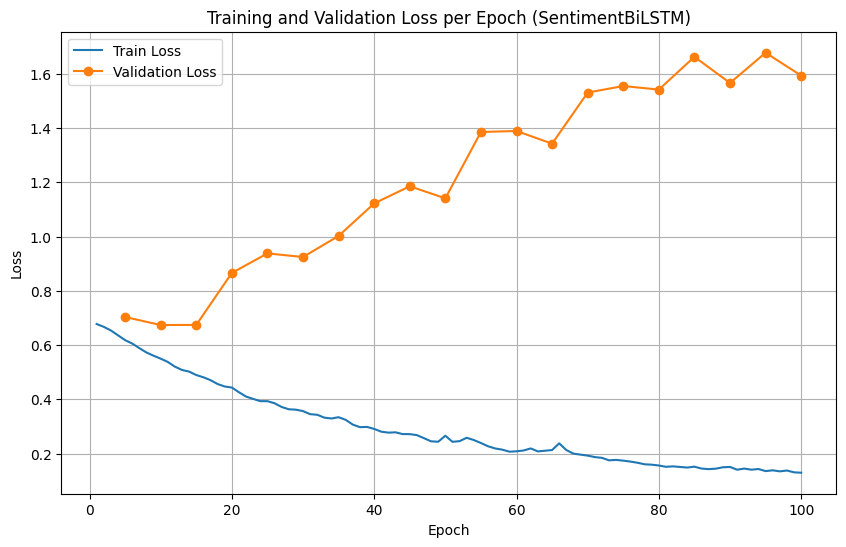

In [ ]:
import matplotlib.pyplot as plt

# Create a list of epochs
epochs = range(1, len(train_losses) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
# Only plot validation loss for epochs where it was recorded
valid_epochs = range(VALIDATION_INTERVAL, EPOCHS + 1, VALIDATION_INTERVAL)
plt.plot(valid_epochs, valid_losses, label='Validation Loss', marker='o')

# Get the model name from the training cell (assuming it's defined there)
# This is a placeholder, you might need to adjust based on how you define the model name
model_name = type(model).__name__

plt.title(f'Training and Validation Loss per Epoch ({model_name})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 11. 모델 평가


In [ ]:
import torch

# Load the best performing model
model.load_state_dict(torch.load('best-model.pt'))

# Evaluate the model on the test set
test_loss = 0
test_acc = 0
model.eval() # Set model to evaluation mode

with torch.no_grad(): # Disable gradient calculation
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)

        predictions = model(features).squeeze(1)

        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.661 | Test Acc: 66.20%
